In [526]:
import numpy as np

import pandas as pd
from pandas.plotting import scatter_matrix

from scipy import stats
import scipy as sc

import matplotlib.pyplot as plt
import seaborn as sns

from random import randrange

import re

import random
import pickle,pprint

from scipy.stats import gamma
from scipy.optimize import minimize

from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy.integrate import odeint
%matplotlib inline

In [527]:


rc('text', usetex=True)

# this is just to have figure with large fontsize
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (8, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


plt.rc('font', weight='bold')
plt.rc('xtick.major', size=5, pad=7)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=20)
plt.rc('axes', titlesize=20)


## Poisson Process with absolute refractory period

In [528]:
def RHO(tau,nu,d):
    if tau< d:
        return 0 
    else:
        return nu

def S(tau,nu,d):
    if tau <d:
        return 1
    else:
        return np.exp(-nu*(tau-d))
    
def P(tau,nu,d):
    if tau <d:
        return 0
    else:
        return nu*np.exp(-nu*(tau-d))
    
    
    

In [529]:
def phih(h,nu_max,beta,h_0):
    return nu_max/(1+np.exp(-beta*(h-h_0)))

def phih_prime(h,nu_max,beta,h_0):
    return beta*phih(h,nu_max,beta,h_0)/(1+np.exp(beta*(h-h_0)))


In [530]:
def Cnm(n,m,h,nu_max,beta,h_0,d):
    
    nu=phih(h,nu_max,beta,h_0)
    
    ln=eigenvalue(n,nu,d)
    lm=eigenvalue(m,nu,d)
    
    if n==m:
        return ln*d*(1+0.5*d*(ln+nu))/(nu*(1+(ln+nu)*d)**2)*phih_prime(h,nu_max,beta,h_0)
    else:
        
        return (ln*(nu+lm))/((ln-lm)*nu*(ln+nu)*(1+d*(lm+nu)))*phih_prime(h,nu_max,beta,h_0)
    

def eigenvalue(n,nu,d):
    return (1/d)*sc.special.lambertw(d*nu*np.exp(nu*d), k=n)-nu

In [531]:
def phi1_0h(h,nu_max,beta,h_0,d):
    nu=phih(h,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    return (nu+l1)/(1+d*(nu+l1))

In [532]:
def RMS(A_n,A_th):
    return  np.sqrt(np.sum((A_n-A_th)**2)/len(A_n))

def NRMS(A_n,A_th):
    return RMS(A_n,A_th)/((np.amax(A_th)-np.amin(A_th)))

In [533]:
def dphi0dh(h,nu_max,beta,h_0,d):
    nu=phih(h,nu_max,beta,h_0)
    nuprime=phih_prime(h,nu_max,beta,h_0)
    
    return nuprime/(1+d*nu)**2



def Jacobian(h_eq,J,nu_max,beta,h_0,tau_m,d):
    
    Jac=np.zeros((3,3))
    phi10=phi1_0h(h_eq,nu_max,beta,h_0,d)
    phi00dh=dphi0dh(h_eq,nu_max,beta,h_0,d)
    c10=Cnm(1,0,h_eq,nu_max,beta,h_0,d)
    nu=phih(h_eq,nu_max,beta,h_0)
    l1=eigenvalue(1,nu,d)
    
    #hpoint
    Jac[0,0]=-1/tau_m+J/tau_m*phi00dh
    Jac[0,1]=2*J/tau_m* phi10.real
    Jac[0,2]=-2*J/tau_m* phi10.imag
    
    #xpoint
    Jac[1,0]=c10.real*Jac[0,0]
    Jac[1,1]=l1.real+c10.real*Jac[0,1]
    Jac[1,2]=-l1.imag+c10.real*Jac[0,2]
    
    #Ypoint
    Jac[2,0]=c10.imag*Jac[0,0]
    Jac[2,1]=l1.imag+c10.imag*Jac[0,1]
    Jac[2,2]=l1.real+c10.imag*Jac[0,2]
    
    return Jac
    
    
def grad_A(h_eq,J,nu_max,beta,h_0,tau_m,d):
    
    phi10=phi1_0h(h_eq,nu_max,beta,h_0,d)
    phi00dh=dphi0dh(h_eq,nu_max,beta,h_0,d)
    
    grad=np.zeros((3,1))
    
    grad[0]=2*phi10.real
    grad[1]=-2*phi10.imag
    grad[2]=phi00dh
    
    return grad
    

In [534]:
def linar_sytem(w,h_eq,J,nu_max,beta,h_0,tau_m,d):
    
    mat=1j*w*np.identity(3)-Jacobian(h_eq,J,nu_max,beta,h_0,tau_m,d)
    b=np.array([1,0,0])  
    
    
    sol=np.linalg.solve(mat, b)
    

    
    return sol

In [535]:
def Spectre_A(w,h_eq,J,nu_max,beta,h_0,tau_m,d):
    
    
    
    hyx=linar_sytem(w,h_eq,J,nu_max,beta,h_0,tau_m,d)
    grad=grad_A(h_eq,J,nu_max,beta,h_0,tau_m,d)
    
    Atilde=np.dot(hyx,grad)[0]
    return (Atilde*(Atilde.real-Atilde.imag*1j)).real


def Spectre_h(w,h_eq,J,nu_max,beta,h_0,tau_m,d):
    hyx=linar_sytem(w,h_eq,J,nu_max,beta,h_0,tau_m,d)
              
    htilde= hyx[0]
              
    return (htilde*(htilde.real-htilde.imag*1j)).real

In [536]:
# uncoupled:

In [561]:
mu=-23
tau_m=10  #ms
J=1000  #mV/kHz
nu_max=0.2 #kHz
h_0=0
beta=0.5
d=10

In [562]:
fun = lambda x: (-x+J*(phih(x,nu_max,beta,h_0))/(1+d*phih(x,nu_max,beta,h_0))+mu)**2

In [563]:

b_coeff=2*(1+d*nu_max)-J*beta*nu_max
c_coeff=(1+d*nu_max)**2


Delta=b_coeff**2-4*c_coeff

two_=True
    
if Delta > 0:

    print('2')
        
    x1=0.5*(-b_coeff+np.sqrt(Delta))
    x2=0.5*(-b_coeff-np.sqrt(Delta))
        
        
    h1=h_0-1/beta*np.log(x1)
    h2=h_0-1/beta*np.log(x2)
        
    print('h',h1,h2)
        
    mu1=h1-J*(phih(h1,nu_max,beta,h_0))/(1+d*phih(h1,nu_max,beta,h_0)) 
    mu2=h2-J*(phih(h2,nu_max,beta,h_0))/(1+d*phih(h2,nu_max,beta,h_0)) 
        
    print('mu1',mu1,'mu2',mu2)
        
    res_1 = minimize(fun, (h1-1), method='SLSQP',tol=10**(-14))
    res_2 = minimize(fun, (h2+1), method='SLSQP',tol=10**(-14))
        
    print('res',res_1.x,res_2.x)
        
        
    if  mu<mu2:
        print('ici')

        h_equilibrium= [res_1.x[0]]
            
    elif mu>mu1:
        print('la')
        
        print(mu,'>',mu1)
        
        h_equilibrium= [res_2.x[0]]
        
    else:
        h_equilibrium= [res_1.x[0],res_2.x[0]]

        
        
else:
        
    print('1')
    
    two_=False
    
    
        
    res_1 = minimize(fun, (1), method='SLSQP',tol=10**(-14))
    h_equilibrium= [res_1.x[0]]
        
    

2
h -9.08454932421 4.69010016954
mu1 -11.1484442587 mu2 -59.9126715626
res [-22.99797199] [ 43.66666665]


In [564]:
h_equilibrium

[-22.997971985453006, 43.666666651901231]

In [565]:
h_vec=np.linspace(-80,40,100)

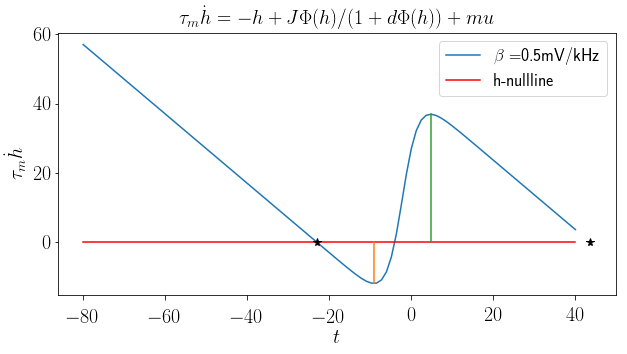

In [566]:
hprime1=np.copy([(-h+J*phih(h,nu_max,beta,h_0)/(1+d*phih(h,nu_max,beta,h_0)) +mu) for h in h_vec])

plt.figure(figsize=(10,5))

plt.title(r'$\tau_m\dot{h}=-h+J\Phi(h)/(1+d\Phi(h))+mu$')
plt.plot(h_vec,hprime1, label=r'$\beta=$'+str(beta)+r'mV/kHz')
plt.plot([h_vec[0],h_vec[-1]],[0,0],c='r',ls='-', label=r'h-nullline')
if two_==True:
    plt.plot([h1,h1],[0,-mu1+mu])
    plt.plot([h2,h2],[0,-mu2+mu])

for idx in h_equilibrium:
    plt.plot(idx,0,marker='*',ms=8,c='k')

plt.ylabel(r'$\tau_m\dot{h}$')
plt.xlabel(r'$t$')
plt.legend()

plt.gcf().subplots_adjust(bottom=0.15)

In [567]:
frequencies=np.logspace(-4,1,50)

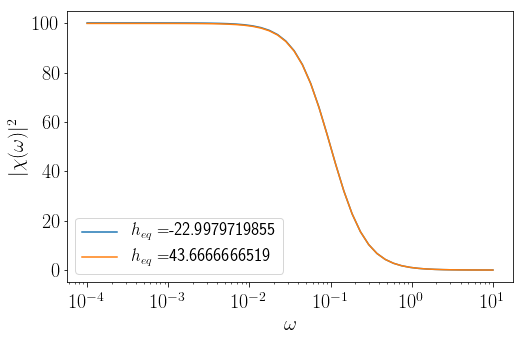

In [568]:
plt.figure()

for h_eq in h_equilibrium:
    h_freq=[Spectre_h(w,h_eq,J,nu_max,beta,h_0,tau_m,d) for w in frequencies]

    plt.semilogx(frequencies,h_freq,label=r'$h_{eq}=$'+str(h_eq))
plt.ylabel(r'$|\chi(\omega)|^2$')
plt.xlabel(r'$\omega$')
plt.legend()



J 10
1
J 200
2
h -5.17921719533 0.784768040653
mu1 -7.62951364843 mu2 -10.0982688396
res [-22.99959472] [ 0.7847681]
ici
J 300
2
h -6.32409871513 1.92964956045
mu1 -8.57813202271 mu2 -15.816317132
res [-22.99939203] [ 1.92964899]
ici
J 400
2
h -7.03696506268 2.64251590801
mu1 -9.21483137556 mu2 -21.8462844458
res [-22.99918929] [ 2.64251589]
ici
J 500
2
h -7.55901623621 3.16456708154
mu1 -9.69601975774 mu2 -28.0317627303
res [-22.99898651] [ 10.26798404]
J 600
2
h -7.97176647805 3.57731732338
mu1 -10.0832226581 mu2 -34.3112264966
res [-22.99878369] [ 16.99728354]
J 1000
2
h -9.08454932421 4.69010016954
mu1 -11.1484442587 mu2 -59.9126715626
res [-22.99797199] [ 43.66666665]


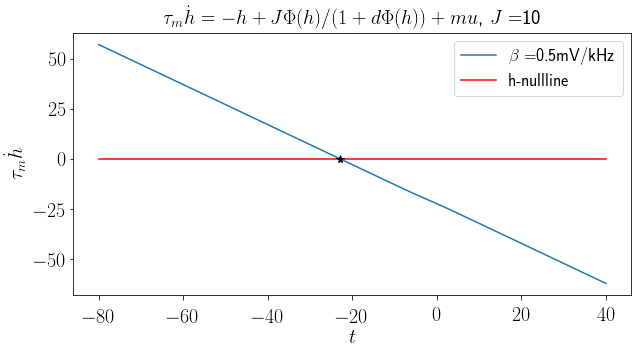

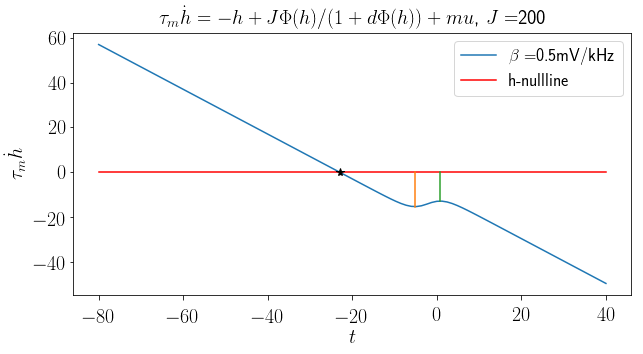

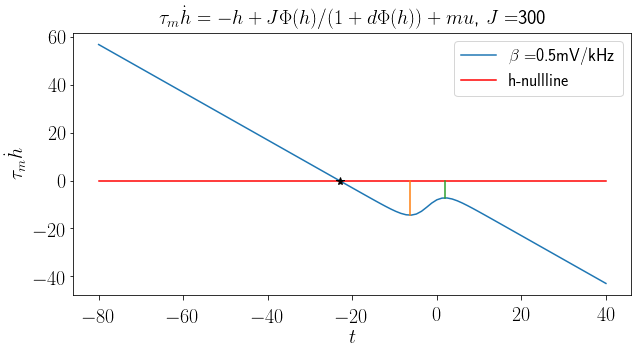

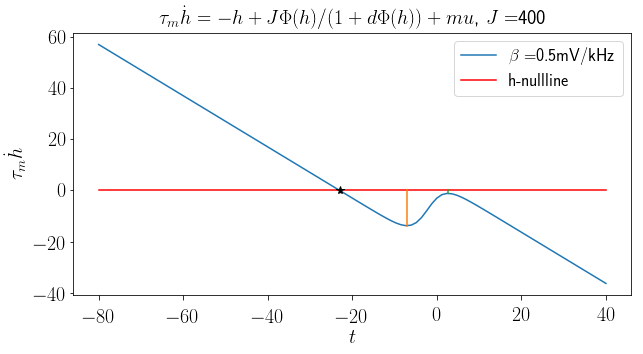

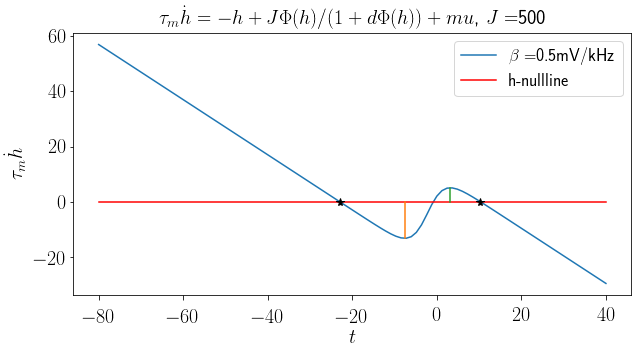

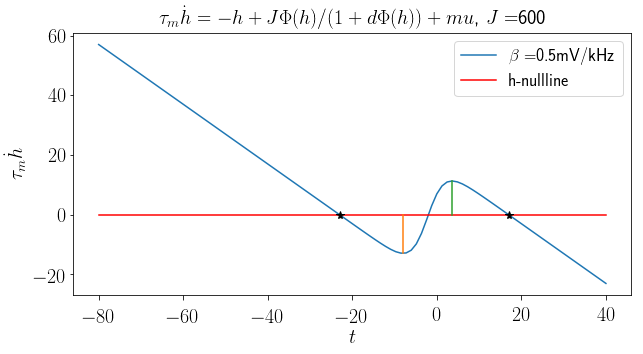

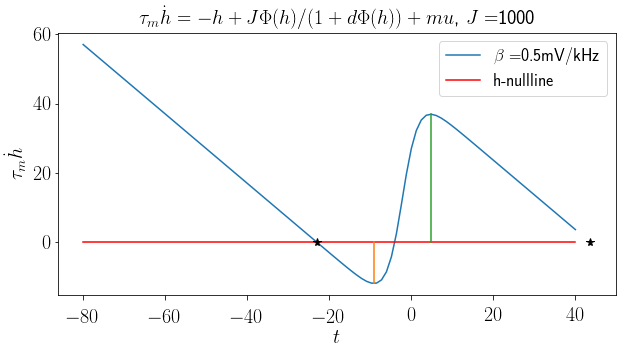

In [575]:
mu=-23
tau_m=10  #ms
#J=500  #mV/kHz
nu_max=0.2 #kHz
h_0=0
beta=0.5
d=10

J_vec=[10,200,300,400,500,600,1000]
J_save=[]
heq_save=[]
hfreq_save=[]


for J in J_vec:
    print('J',J)

    fun = lambda x: (-x+J*(phih(x,nu_max,beta,h_0))/(1+d*phih(x,nu_max,beta,h_0))+mu)**2


    b_coeff=2*(1+d*nu_max)-J*beta*nu_max
    c_coeff=(1+d*nu_max)**2


    Delta=b_coeff**2-4*c_coeff

    two_=True
    
    if Delta > 0:

        print('2')
        
        x1=0.5*(-b_coeff+np.sqrt(Delta))
        x2=0.5*(-b_coeff-np.sqrt(Delta))
        
        
        h1=h_0-1/beta*np.log(x1)
        h2=h_0-1/beta*np.log(x2)
        
        print('h',h1,h2)
        
        mu1=h1-J*(phih(h1,nu_max,beta,h_0))/(1+d*phih(h1,nu_max,beta,h_0)) 
        mu2=h2-J*(phih(h2,nu_max,beta,h_0))/(1+d*phih(h2,nu_max,beta,h_0)) 
        
        print('mu1',mu1,'mu2',mu2)
        
        res_1 = minimize(fun, (h1-1), method='SLSQP',tol=10**(-14))
        res_2 = minimize(fun, (h2+1), method='SLSQP',tol=10**(-14))
        
        print('res',res_1.x,res_2.x)
        
        
        if  mu<mu2:
            print('ici')

            h_equilibrium= [res_1.x[0]]
            
        elif mu>mu1:
            print('la')
        
            print(mu,'>',mu1)
        
            h_equilibrium= [res_2.x[0]]
        
        else:
            h_equilibrium= [res_1.x[0],res_2.x[0]]

        
        
    else:
        
        print('1')
    
        two_=False
    
    
        
        res_1 = minimize(fun, (1), method='SLSQP',tol=10**(-14))
        h_equilibrium= [res_1.x[0]]
        
    

    h_equilibrium

    h_vec=np.linspace(-80,40,100)

    hprime1=np.copy([(-h+J*phih(h,nu_max,beta,h_0)/(1+d*phih(h,nu_max,beta,h_0)) +mu) for h in h_vec])

    plt.figure(figsize=(10,5))

    plt.title(r'$\tau_m\dot{h}=-h+J\Phi(h)/(1+d\Phi(h))+mu$,   $J=$'+str(J))
    plt.plot(h_vec,hprime1, label=r'$\beta=$'+str(beta)+r'mV/kHz')
    plt.plot([h_vec[0],h_vec[-1]],[0,0],c='r',ls='-', label=r'h-nullline')
    if two_==True:
        plt.plot([h1,h1],[0,-mu1+mu])
        plt.plot([h2,h2],[0,-mu2+mu])

    for idx in h_equilibrium:
        plt.plot(idx,0,marker='*',ms=8,c='k')

    plt.ylabel(r'$\tau_m\dot{h}$')
    plt.xlabel(r'$t$')
    plt.legend()

    plt.gcf().subplots_adjust(bottom=0.15)



    frequencies=np.logspace(-4,1,50)

    plt.figure()

    for h_eq in h_equilibrium:
        h_freq=[Spectre_h(w,h_eq,J,nu_max,beta,h_0,tau_m,d) for w in frequencies]

        J_save.append(J)
        heq_save.append(h_eq)
        hfreq_save.append(h_freq)



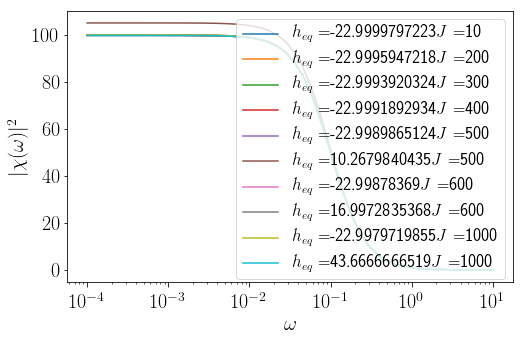

In [574]:
plt.figure()

for i in range(len(J_save)):
    plt.semilogx(frequencies,hfreq_save[i],label=r'$h_{eq}=$'+str(heq_save[i])+r'$J=$'+str(J_save[i]))
plt.ylabel(r'$|\chi(\omega)|^2$')
plt.xlabel(r'$\omega$')
plt.legend()


# COUPLED NETWORK

In [152]:
def hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t):
    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    
def f(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)+Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint


def g(l1,h,h_0,d,nu_max,beta,hpoint):
    return l1+(Cnm(1,1,h,nu_max,beta,h_0,d)-Cnm(1,-1,h,nu_max,beta,h_0,d))*hpoint

       
def c10(h,nu_max,beta,h_0,d,hpoint):
    return Cnm(1,0,h,nu_max,beta,h_0,d)*hpoint


def KLM(h,U,V,h_0,tau_m,J,d,nu_max,beta,t):
    
    nu=phih(h,nu_max,beta,h_0)
    
    l1=eigenvalue(1,nu,d)
    
    phi1_0= phi1_0h(h,nu_max,beta,h_0,d)

    A_inf=nu/(d*nu+1)
    
    hpoint=hpoint_f(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    ff=f(l1,h,h_0,d,nu_max,beta,hpoint)
    gg=g(l1,h,h_0,d,nu_max,beta,hpoint)
    cc=c10(h,nu_max,beta,h_0,d,hpoint)
    
    K_=K(ff,gg,cc,U,V)
    L_=L(ff,gg,cc,U,V)
    M_=M(h,tau_m,J,A_inf,U,V,phi1_0,t)
    
    
    return K_,L_,M_


def K(f,g,c,U,V):
    return (f.real*U-g.imag*V+c.real)

def L(f,g,c,U,V):
    return (g.real*V+f.imag*U+c.imag) 

def M(h,tau_m,J,A_inf,U,V,phi1_0,t):
    return -h/tau_m + J/tau_m*(A_inf +2*(U*phi1_0.real-V*phi1_0.imag))+ mu(t)/tau_m
    



In [13]:
#REFRACTORINESS
d=10

#TIME PARAMETER
dt=0.01

t_max=100#100
N_sim=int(t_max/dt)
tsim=[i*dt for i in range(N_sim)]
tsim_num=[i*dt for i in range(N_sim)]

#NU PARAMETER 

nu_max=0.2  #kHz
h_0=15 #mV

A_h0=0.5*nu_max/(1+0.5*nu_max*d)
A_max=nu_max/(1+nu_max*d)


tau_m=10  #ms
J=500  #mV/kHz


beta=2/(J*nu_max)  #mV^-1
print(beta)


#mu_0_vec=[-5,-10,-15]
epsilon_vec=[-1,-0.1,0.1,1,10]#,2,5,10]

# Activity Matrix
A_Matrix   =np.zeros((len(epsilon_vec),N_sim))
A_wc_Matrix=np.zeros((len(epsilon_vec),N_sim))

0.02


In [9]:
mu_0=h_0-J*A_h0
print(mu_0,A_h0,A_max)

-10.0 0.05 0.06666666666666667


In [218]:
h_vec=np.linspace(-20,40,100)

In [248]:
hprime1=np.copy([(-h+J*phih(h,nu_max,0.5,h_0)/(1+d*phih(h,nu_max,0.5,h_0))) for h in h_vec])
hprime2=np.copy([(-h+J*phih(h,nu_max,0.1,h_0)/(1+d*phih(h,nu_max,0.1,h_0))) for h in h_vec])

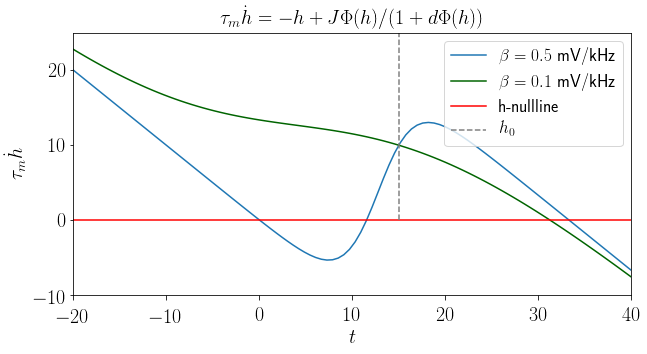

In [255]:
plt.figure(figsize=(10,5))

plt.title(r'$\tau_m\dot{h}=-h+J\Phi(h)/(1+d\Phi(h))$')
plt.plot(h_vec,hprime1, label=r'$\beta=0.5$ mV/kHz')
plt.plot(h_vec,hprime2,c='darkgreen', label=r'$\beta=0.1$ mV/kHz')
plt.plot([-20,40],[0,0],c='r',ls='-', label=r'h-nullline$')
plt.plot([h_0,h_0],[0,25],c='grey',ls='--', label=r'$h_0$')
plt.xlim(-20,40)
plt.ylim(-10,25)

plt.ylabel(r'$\tau_m\dot{h}$')
plt.xlabel(r'$t$')
plt.legend()

plt.gcf().subplots_adjust(bottom=0.15)
#plt.savefig('h.pdf')

In [ ]:
test=[Spectre_A(w,h_equilibrium,J,nu_max,beta,h_0,tau_m,d) for w in frequencies]

In [216]:
for i_o, epsilon in enumerate(epsilon_vec):
    print(i_o)
    
    def mu(t):
        return mu_0 + epsilon/(1+np.exp(-(t-5)))
            
    A=np.zeros((N_sim,1))

    U=np.zeros((N_sim+1,1))
    U[0]=0

    V=np.zeros((N_sim+1,1))
    V[0]=0

    h=np.zeros((N_sim+1,1))
    h[0]=h_0#J*A_max #h_0

    h_wc=np.zeros((N_sim+1,1))
    h_wc[0]=h_0#J*A_max #h_0


    A_wc=np.zeros((N_sim+1,1))
    nu_0=phih(h[0],nu_max,beta,h_0)
    A_wc[0]=nu_0/(1+d*nu_0)


    d_index=int(d/dt)

    for i in range(N_sim):
        t=i*dt
    
    
        if i<d_index:
            jstart=0
            first_A=d_index-i-1
        else:
            jstart=i-d_index+1
            first_A=0
    
        K1,L1,M1=KLM((h[i]),(U[i]),(V[i]),h_0,tau_m,J,d,nu_max,beta,t)
    
        K2,L2,M2=KLM((h[i]+0.5*dt*M1),(U[i]+0.5*dt*K1),(V[i]+0.5*dt*L1),h_0,tau_m,J,d,nu_max,beta,t)
        
        K3,L3,M3=KLM((h[i]+0.5*dt*M2),(U[i]+0.5*dt*K2),(V[i]+0.5*dt*L2),h_0,tau_m,J,d,nu_max,beta,t)
    
        K4,L4,M4=KLM((h[i]+dt*M3),(U[i]+dt*K3),(V[i]+dt*L3),h_0,tau_m,J,d,nu_max,beta,t)
    
    
        U[i+1]=U[i]+dt/6*(K1+2*K2+2*K3+K4)
        V[i+1]=V[i]+dt/6*(L1+2*L2+2*L3+L4)
        h[i+1]=h[i]+dt/6*(M1+2*M2+2*M3+M4)
    
    
        nu=phih(h[i],nu_max,beta,h_0)
        phi1_0= phi1_0h(h[i],nu_max,beta,h_0,d)
        A_inf=nu/(d*nu+1)
    
        A[i]=A_inf+2*(U[i]*phi1_0.real-V[i]*phi1_0.imag)
    
        h_wc[i+1]=(1-dt/tau_m)*h_wc[i]+dt/tau_m*(J*A_wc[i]+mu(t))
        nu_wc=phih(h_wc[i],nu_max,beta,h_0)
        A_wc[i+1]=nu_wc*(1-(np.sum(A_wc[jstart:i+1])+first_A*A_wc[0])*dt)
   
    A_wc=A_wc[:-1]
    
    A_Matrix[i_o,:]=A.flatten()
    A_wc_Matrix[i_o,:]=A_wc.flatten()

0
1
2
3
4


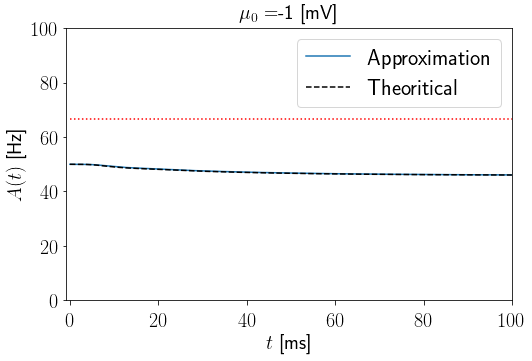

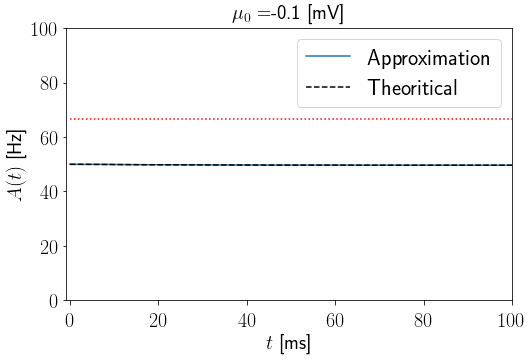

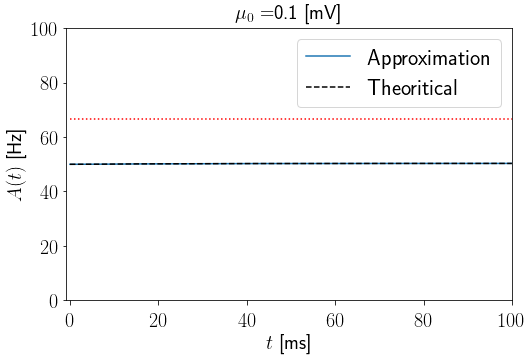

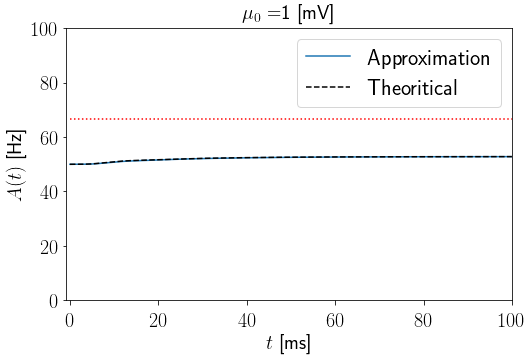

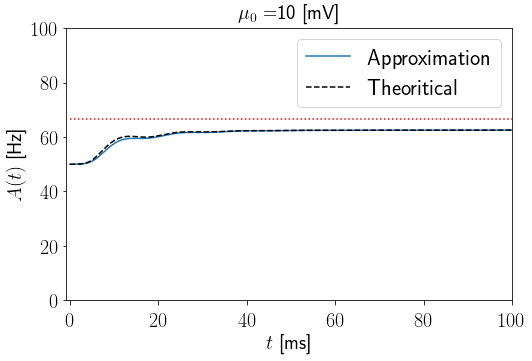

In [217]:
for i_o, mu_0 in enumerate(epsilon_vec):
    plt.figure()
    plt.plot(tsim,1000*A_Matrix[i_o,:],label='Approximation')
    plt.plot(tsim_num,1000*A_wc_Matrix[i_o,:],label='Theoritical',c='k',ls='--')
    plt.plot([tsim[0],tsim[-1]],[1000*A_max,1000*A_max],c='r',ls=':')
    plt.title(r'$\mu_{0}=$'+str(mu_0)+' [mV]')
    #, $\epsilon=$'+str(epsilon_vec[i_e])+ r' [mV] $, NRMS=$'+str(np.round(NRMS_matrix[i_o,i_e],2)))
    plt.legend(fontsize=22)
    plt.ylabel(r'$A(t)$ [Hz]')
    plt.xlabel(r'$t$ [ms]')
    plt.xlim(-1,t_max)
    plt.ylim(-1,100)
    plt.gca().set_ylim(bottom=0)